# Прогноз оттока клиентов

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

**Описание услуг**

Оператор предоставляет два основных типа услуг: 

1) Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
2) Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:

- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

**Описание данных**

Данные состоят из нескольких файлов, полученных из разных источников:

contract_new.csv — информация о договоре;
personal_new.csv — персональные данные клиента;
internet_new.csv — информация об интернет-услугах;
phone_new.csv — информация об услугах телефонии.

**Файл contract_new.csv**
customerID — идентификатор абонента;
BeginDate — дата начала действия договора;
EndDate — дата окончания действия договора;
Type — тип оплаты: раз в год-два или ежемесячно;
PaperlessBilling — электронный расчётный лист;
PaymentMethod — тип платежа;
MonthlyCharges — расходы за месяц;
TotalCharges — общие расходы абонента.

**Файл personal_new.csv**
customerID — идентификатор пользователя;
gender — пол;
SeniorCitizen — является ли абонент пенсионером;
Partner — есть ли у абонента супруг или супруга;
Dependents — есть ли у абонента дети.

**Файл internet_new.csv**
customerID — идентификатор пользователя;
InternetService — тип подключения;
OnlineSecurity — блокировка опасных сайтов;
OnlineBackup — облачное хранилище файлов для резервного копирования данных;
DeviceProtection — антивирус;
TechSupport — выделенная линия технической поддержки;
StreamingTV — стриминговое телевидение;
StreamingMovies — каталог фильмов.

**Файл phone_new.csv**
customerID — идентификатор пользователя;
MultipleLines — подключение телефона к нескольким линиям одновременно.
Во всех файлах столбец customerID содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года.

**План работы:**
1. Загрузка данных
2. Исследовательский анализ и предобработка данных
3. Объединение данных
4. Исследовательский анализ и предобработка данных объединённого датафрейма
5. Подготовка данных
6. Обучение моделей машинного обучения
7. Выбор лучшей модели
8. Общий вывод и рекомендации заказчику

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import phik
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, roc_auc_score, confusion_matrix, accuracy_score
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

R_STATE = 20824

## 1. Загрузка данных

In [2]:
try:
    contract = pd.read_csv('/datasets/contract_new.csv')
except:
    contract = pd.read_csv("C:/Users/chern/contract_new.csv")
    
display(contract.head(10))
display(contract.info())

try:
    personal = pd.read_csv('/datasets/personal_new.csv')
except:
    personal = pd.read_csv("C:/Users/chern/personal_new.csv")
    
display(personal.head(10))
display(personal.info())

try:
    internet = pd.read_csv('/datasets/internet_new.csv')
except:
    internet = pd.read_csv("C:/Users/chern/internet_new.csv")
    
display(internet.head(10))
display(internet.info())

try:
    phone = pd.read_csv('/datasets/phone_new.csv')
except:
    phone = pd.read_csv("C:/Users/chern/phone_new.csv")
    
display(phone.head(10))
display(phone.info())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

**Вывод:**

Данные представлены в 4 датафреймах.
- Contract состоит из 8 столбцов и 7043 строк и содержит категориальные и численные данные. Столбец total charges требует замены типа данных на float. 
- Personal состоит из 5 столбцов и 7043 строк. Содержит категориальные и численные данные.
- Internet состоит из 8 столбцов и 5517 строк, содержит категориальные данные
- Phone состоит из 2 столбцов и 6361, содержит категориальные данные


## 2. Исследовательский анализ и предобработка данных

Приведем названия столбцов к змеиному типу:

In [3]:
contract = contract.rename(columns=lambda x: re.sub(r'(?<!^)([A-Z])', r'_\1', x).lower())  
personal = personal.rename(columns=lambda x: re.sub(r'(?<!^)([A-Z])', r'_\1', x).lower()) 
internet = internet.rename(columns=lambda x: re.sub(r'(?<!^)([A-Z])', r'_\1', x).lower()) 
phone = phone.rename(columns=lambda x: re.sub(r'(?<!^)([A-Z])', r'_\1', x).lower()) 

display(contract, personal, internet, phone)

,customer_i_d,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,2035.2
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7430.4
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,325.6
7041,8361-LTMKD,2019-07-01,No,Month-to-month,Yes,Mailed check,74.40,520.8


,customer_i_d,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


,customer_i_d,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


,customer_i_d,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


Рассмотрим столбец total charges датафрейма contract и поменяем тип данных на float:

In [4]:
contract['total_charges'].sort_values().unique()

array([' ', '100.17', '100.19', ..., '998.89', '999.6', '999.9'],
      dtype=object)

In [5]:
contract.loc[contract['total_charges'] == ' ', 'total_charges'] = -1
contract['total_charges'] = contract['total_charges'].astype('float64')

contract.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_i_d       7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


In [6]:
contract['total_charges'].unique()

array([  31.04, 2071.84,  226.17, ...,  325.6 ,  520.8 , 7251.82])

Проверим датафреймы на налечие дубликатов и пропусков:

In [7]:
display(contract.duplicated().sum())
display(personal.duplicated().sum())
display(internet.duplicated().sum())
display(phone.duplicated().sum())

0

0

0

0

In [8]:
display(contract.isna().sum())
display(personal.isna().sum())
display(internet.isna().sum())
display(phone.isna().sum())

customer_i_d         0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
dtype: int64

customer_i_d      0
gender            0
senior_citizen    0
partner           0
dependents        0
dtype: int64

customer_i_d         0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_t_v        0
streaming_movies     0
dtype: int64

customer_i_d      0
multiple_lines    0
dtype: int64

In [9]:
display(contract[contract.duplicated('customer_i_d')].count())
display(contract[contract.duplicated('customer_i_d')])

display(personal[personal.duplicated('customer_i_d')].count())
display(personal[personal.duplicated('customer_i_d')])

display(internet[internet.duplicated('customer_i_d')].count())
display(internet[internet.duplicated('customer_i_d')])

display(phone[phone.duplicated('customer_i_d')].count())
display(phone[phone.duplicated('customer_i_d')])

customer_i_d         0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
dtype: int64

,customer_i_d,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges


customer_i_d      0
gender            0
senior_citizen    0
partner           0
dependents        0
dtype: int64

,customer_i_d,gender,senior_citizen,partner,dependents


customer_i_d         0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_t_v        0
streaming_movies     0
dtype: int64

,customer_i_d,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies


customer_i_d      0
multiple_lines    0
dtype: int64

,customer_i_d,multiple_lines


Создадим новый столбец с целевым признаком, с информацией о статусе договора из столбца end date:

In [10]:
contract_new = contract.copy()

In [11]:
contract_new['end_date'].unique()

array(['No', '2017-05-01', '2016-03-01', '2018-09-01', '2018-11-01',
       '2018-12-01', '2019-08-01', '2018-07-01', '2017-09-01',
       '2015-09-01', '2016-07-01', '2016-06-01', '2018-03-01',
       '2019-02-01', '2018-06-01', '2019-06-01', '2020-01-01',
       '2019-11-01', '2016-09-01', '2015-06-01', '2016-12-01',
       '2019-05-01', '2019-04-01', '2017-06-01', '2017-08-01',
       '2018-04-01', '2018-08-01', '2018-02-01', '2019-07-01',
       '2015-12-01', '2014-06-01', '2018-10-01', '2019-01-01',
       '2017-07-01', '2017-12-01', '2018-05-01', '2015-11-01',
       '2019-10-01', '2019-03-01', '2016-02-01', '2016-10-01',
       '2018-01-01', '2017-11-01', '2015-10-01', '2019-12-01',
       '2015-07-01', '2017-04-01', '2015-02-01', '2017-03-01',
       '2016-05-01', '2016-11-01', '2015-08-01', '2019-09-01',
       '2017-10-01', '2017-02-01', '2016-08-01', '2016-04-01',
       '2015-05-01', '2014-09-01', '2014-10-01', '2017-01-01',
       '2015-03-01', '2015-01-01', '2016-01-01', 

In [12]:
contract_new['active'] = 1
contract_new.loc[contract_new['end_date'] == 'No', 'active'] = 0

In [13]:
contract_new

,customer_i_d,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,active
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,0
...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,2035.20,0
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7430.40,0
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,325.60,0
7041,8361-LTMKD,2019-07-01,No,Month-to-month,Yes,Mailed check,74.40,520.80,0


In [14]:
contract_new['active'].unique()

array([0, 1], dtype=int64)

Создадим новый столбец duration с информацией о сроке действия договоров:

In [15]:
contract_new.loc[contract_new['end_date'] == 'No', 'end_date'] = '2020-02-01'
contract_new['end_date'] = pd.to_datetime(contract_new['end_date'], format='%Y-%m-%d')


contract_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_i_d       7043 non-null   object        
 1   begin_date         7043 non-null   object        
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   active             7043 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 495.3+ KB


In [16]:
contract_new['end_date'].unique()

<DatetimeArray>
['2020-02-01 00:00:00', '2017-05-01 00:00:00', '2016-03-01 00:00:00',
 '2018-09-01 00:00:00', '2018-11-01 00:00:00', '2018-12-01 00:00:00',
 '2019-08-01 00:00:00', '2018-07-01 00:00:00', '2017-09-01 00:00:00',
 '2015-09-01 00:00:00', '2016-07-01 00:00:00', '2016-06-01 00:00:00',
 '2018-03-01 00:00:00', '2019-02-01 00:00:00', '2018-06-01 00:00:00',
 '2019-06-01 00:00:00', '2020-01-01 00:00:00', '2019-11-01 00:00:00',
 '2016-09-01 00:00:00', '2015-06-01 00:00:00', '2016-12-01 00:00:00',
 '2019-05-01 00:00:00', '2019-04-01 00:00:00', '2017-06-01 00:00:00',
 '2017-08-01 00:00:00', '2018-04-01 00:00:00', '2018-08-01 00:00:00',
 '2018-02-01 00:00:00', '2019-07-01 00:00:00', '2015-12-01 00:00:00',
 '2014-06-01 00:00:00', '2018-10-01 00:00:00', '2019-01-01 00:00:00',
 '2017-07-01 00:00:00', '2017-12-01 00:00:00', '2018-05-01 00:00:00',
 '2015-11-01 00:00:00', '2019-10-01 00:00:00', '2019-03-01 00:00:00',
 '2016-02-01 00:00:00', '2016-10-01 00:00:00', '2018-01-01 00:00:00',
 '20

In [17]:
contract_new['end_year'] = contract_new['end_date'].dt.year

In [18]:
contract_new['begin_date'] = pd.to_datetime(contract_new['begin_date'], format='%Y-%m-%d')
contract_new['begin_year'] = contract_new['begin_date'].dt.year

In [19]:
contract_new['duration'] = contract_new['end_year'] - contract_new['begin_year'] 

contract_new.head()

,customer_i_d,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,active,end_year,begin_year,duration
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,2020,2020,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,2020,2017,3
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,2020,2019,1
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,2020,2016,4
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,2020,2019,1


Рассмотрим столбец с целевым признаком active:

active
0    0.843675
1    0.156325
Name: proportion, dtype: float64


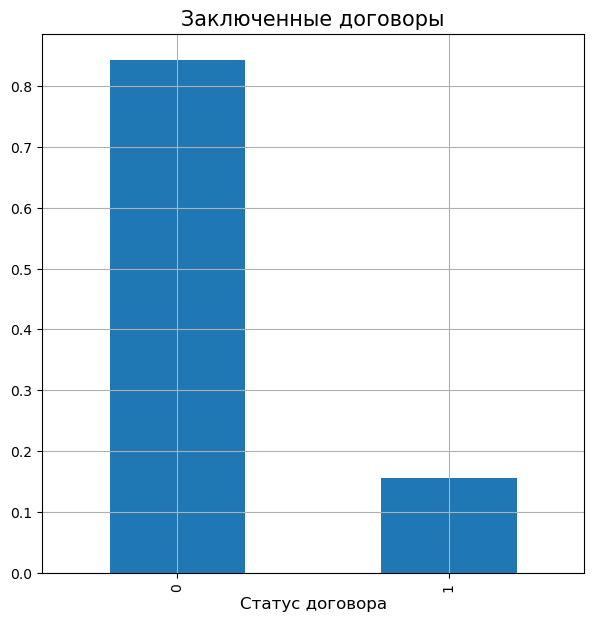

In [20]:
active = contract_new['active'].value_counts(normalize=True)
print(active)

active.plot(kind='bar', grid=True, figsize=(7, 7))
plt.title('Заключенные договоры', fontsize=15)
plt.xlabel('Статус договора', fontsize=12)
plt.show();

16% клиентов отказались от услуг связи, что говорит о диссбалансе классов. Для обучения моделей классы необходимо будет сбалансировать.

Посмотрим числовые признаки из датафрейма contract на гистограмме:

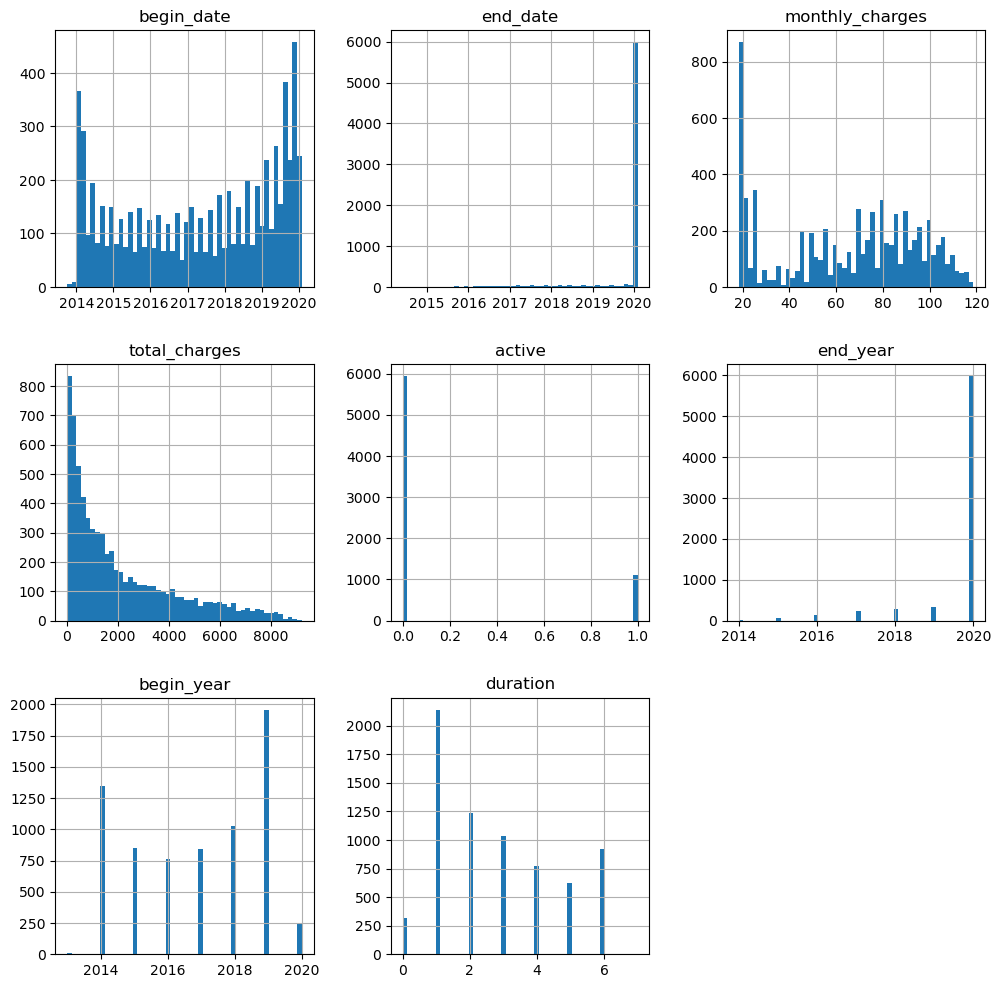

In [21]:
contract_new.hist(figsize=(12,12), bins=50);

- Количество завершенных контрактов медленно, но стабильно растет
- Также после спада в 2015 году уверенно растет и количество новых договоров. Наибольшее количество договоров заключено в 2019 году.
- Большего всего контрактов закрываются через год, однако большая часть клиентов пользуется услугами от 2 и более лет. Совсем мало тех, кто использует услуги связи меньше года.

Столбцы с датами не важны для обучения моделей, их нужно будет удалить.

Информацию о расходах клиентов рассмотрим подробнее на диаграммах размаха:

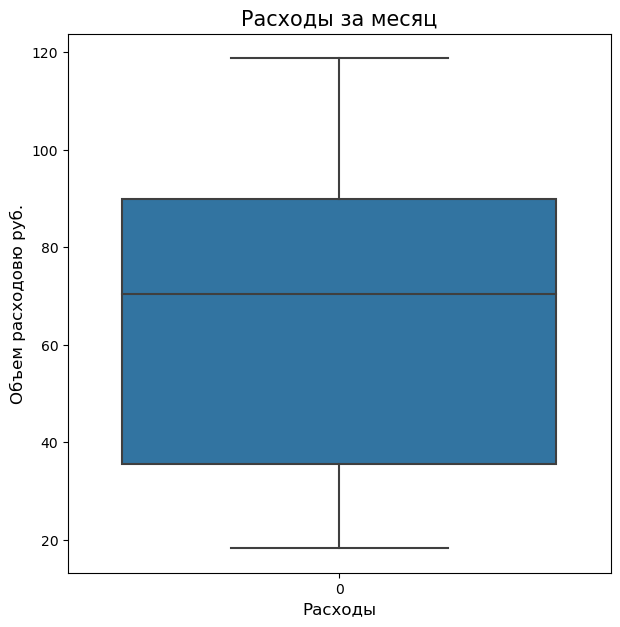

In [22]:
plt.figure(figsize=(7,7))
sns.boxplot(data=contract_new['monthly_charges'])
plt.title('Расходы за месяц', fontsize=15)
plt.xlabel('Расходы', fontsize=12)
plt.ylabel('Объем расходовю руб.',fontsize=12);

In [23]:
contract_new['monthly_charges'].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: monthly_charges, dtype: float64

Информация о расходах за месяц не содержит выбросов.
Заказчик не предоставил информацию о валюте расходов, но логически можно предположить, что расходы указаны в рублях.
Большая часть клиентов тратит в месяц от 35 до 90 руб.
Средняя трата составляет 65 руб. 


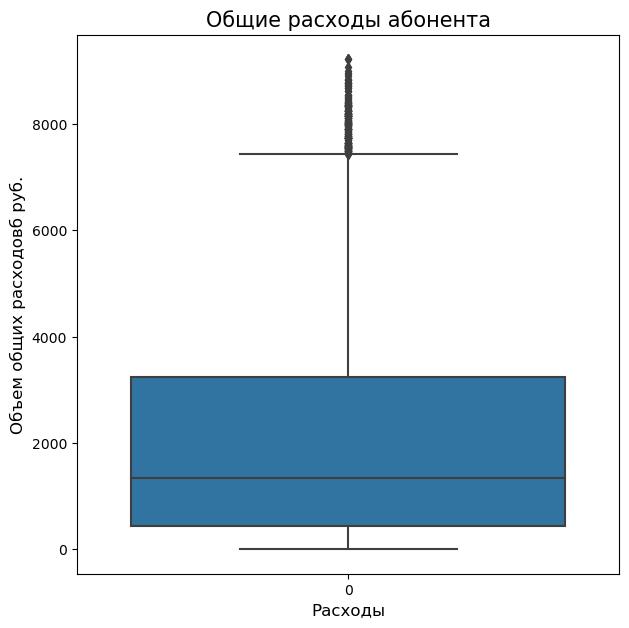

In [24]:
plt.figure(figsize=(7,7))
sns.boxplot(data=contract_new['total_charges'])
plt.title('Общие расходы абонента', fontsize=15)
plt.xlabel('Расходы', fontsize=12)
plt.ylabel('Объем общих расходовб руб.',fontsize=12);

In [25]:
contract_new['total_charges'].describe()

count    7043.000000
mean     2115.311323
std      2112.744378
min        -1.000000
25%       436.750000
50%      1343.350000
75%      3236.690000
max      9221.380000
Name: total_charges, dtype: float64

Информация об общих расходах абонентов содержит большое количество выбросов у верхней границы.
Большая часть клиентов потратила в общем от 500 до 3500 руб.
Средняя трата составляет 2115 руб. 


Уменьшим количество выбросов у верхней границы:

In [26]:
#contract_new = contract_new.query('total_charges < 8000')

In [27]:
#contract_new['total_charges'].describe()

**Вывод:**

- Провели предобработку данных, проверили на наличие дубликатов и пропусков
- Создали новые столбцы:
  - active с целевым признаком, с информацией о статусе договора из столбца end date
  - duration со сроком действия договоров.
- Использованные столбцы с датами не важны для обучения моделей их нужно будет удалить.
- Выявили дисбаланс классов в таргете - 84:16. Для обучения моделей классы необходимо будет сбалансировать.

- Рассмотрели данные на графиках:
  - Количество завершенных контрактов медленно, но стабильно растет
  - Также после спада в 2015 году уверенно растет и количество новых договоров. Наибольшее количество договоров заключено в 2019 году.
  - Большего всего контрактов закрываются через год, однако большая часть клиентов пользуется услугами от 2 и более лет. Совсем мало тех, кто использует услуги связи меньше года.
  - Информация о расходах за месяц не содержит выбросов. Заказчик не предоставил информацию о валюте расходов, но логически можно предположить, что расходы указаны в рублях. Большая часть клиентов тратит в месяц от 35 до 90 руб. Средняя трата составляет 65 руб. 
  - Информация об общих расходах абонентов содержит большое количество выбросов у верхней границы. Большая часть клиентов потратила в общем от 500 до 3500 руб. Средняя трата составляет 2115 руб.
 

## 3. Объединение данных

Соберем данные в единый датафрейм telecom:

In [28]:
telecom = contract_new.merge(personal, on=['customer_i_d'], how='left')
telecom = telecom.merge(internet, on=['customer_i_d'], how='left')
telecom = telecom.merge(phone, on=['customer_i_d'], how='left')

telecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_i_d       7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   active             7043 non-null   int64         
 9   end_year           7043 non-null   int32         
 10  begin_year         7043 non-null   int32         
 11  duration           7043 non-null   int32         
 12  gender             7043 non-null   object        
 13  senior_citizen     7043 non-null   int64         
 14  partner 

Удалим столбцы с датами и идентификатором:

In [29]:
telecom = telecom.drop(['customer_i_d', 'begin_date', 'end_date', 'end_year', 'begin_year'], axis=1)
telecom.shape

(7043, 19)

In [30]:
telecom.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,active,duration,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines
0,Month-to-month,Yes,Electronic check,29.85,31.04,0,0,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,One year,No,Mailed check,56.95,2071.84,0,3,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,Month-to-month,Yes,Mailed check,53.85,226.17,0,1,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,One year,No,Bank transfer (automatic),42.30,1960.60,0,4,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,Month-to-month,Yes,Electronic check,70.70,353.50,0,1,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


**Вывод:**

Содан общий датафрейм telecom, содержащий 19 столбцов и 6944 строк. Удалили лишние столбцы.

## 4. Исследовательский анализ и предобработка данных объединённого датафрейма

Проведем предобработку нового датафрейма, заполним образовавшиеся пропуски

In [31]:
telecom.duplicated().sum()

4

In [32]:
telecom = telecom.drop_duplicates()

In [33]:
telecom.isna().sum()

type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
active                  0
duration                0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1523
online_security      1523
online_backup        1523
device_protection    1523
tech_support         1523
streaming_t_v        1523
streaming_movies     1523
multiple_lines        682
dtype: int64

In [34]:
telecom = telecom.fillna('Unknown')

Составим типичный портрет клиентов, которые продолжают пользоваться услугами и тех, кто отказался от услуг.
Для этого рассмотрим распределение классов на графиках:

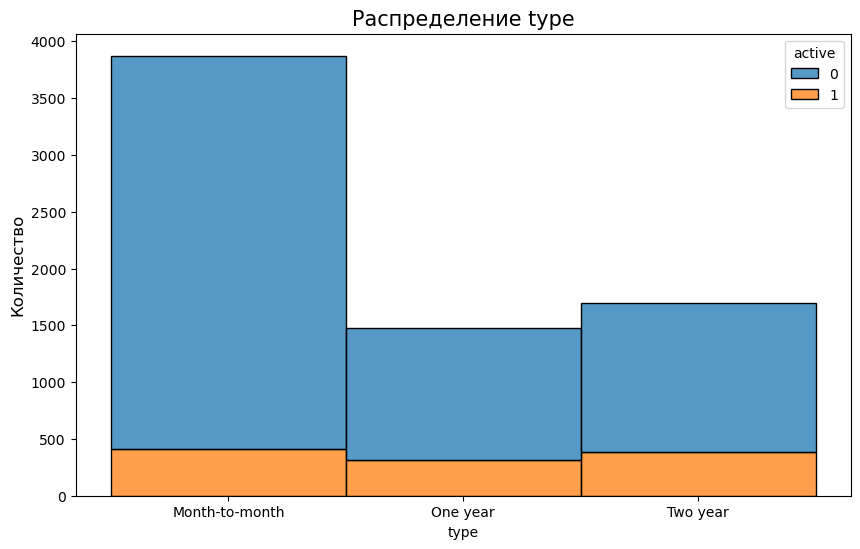

In [35]:
plt.figure(figsize=(10, 6))

sns.histplot(data=telecom, x='type', hue='active', multiple='stack')

plt.title('Распределение type', fontsize=15)
plt.ylabel('Количество', fontsize=12);

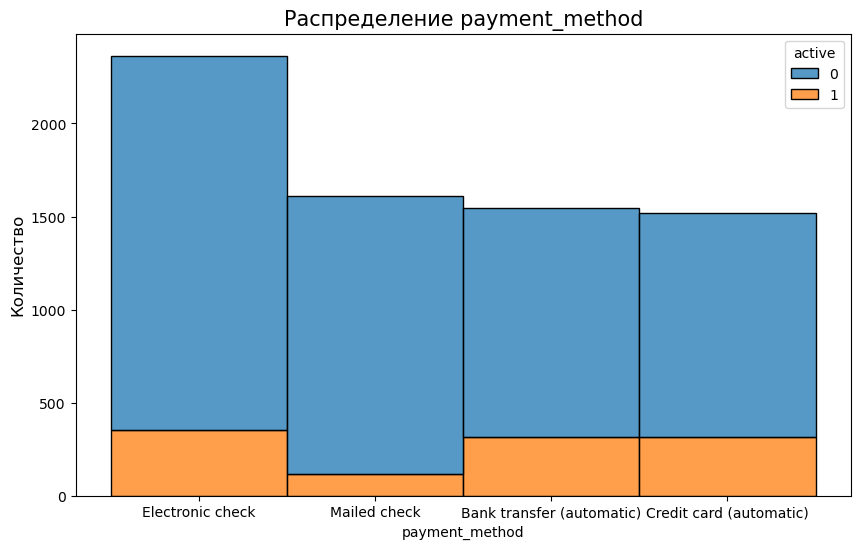

In [36]:
plt.figure(figsize=(10, 6))

sns.histplot(data=telecom, x='payment_method', hue='active', multiple='stack')

plt.title('Распределение payment_method', fontsize=15)
plt.ylabel('Количество', fontsize=12);

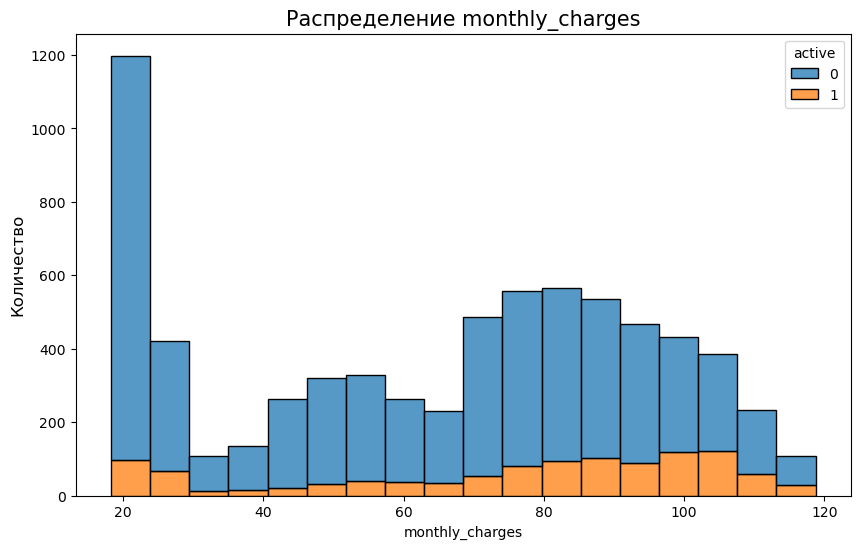

In [37]:
plt.figure(figsize=(10, 6))

sns.histplot(data=telecom, x='monthly_charges', hue='active', multiple='stack')

plt.title('Распределение monthly_charges', fontsize=15)
plt.ylabel('Количество', fontsize=12);

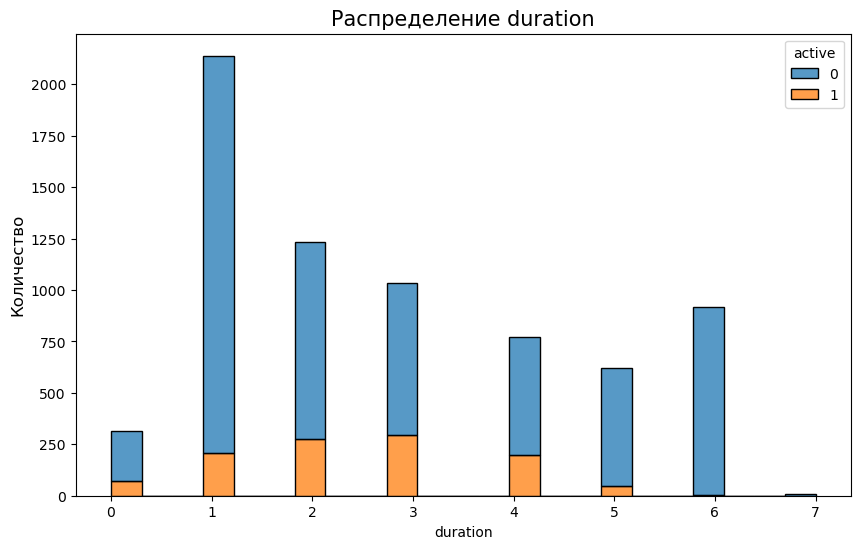

In [38]:
plt.figure(figsize=(10, 6))

sns.histplot(data=telecom, x='duration', hue='active', multiple='stack')

plt.title('Распределение duration', fontsize=15)
plt.ylabel('Количество', fontsize=12);

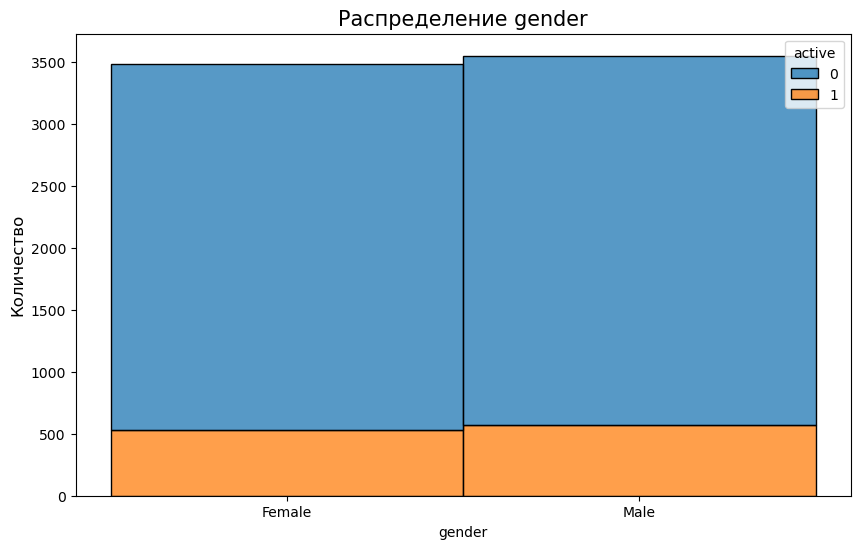

In [39]:
plt.figure(figsize=(10, 6))

sns.histplot(data=telecom, x='gender', hue='active', multiple='stack')

plt.title('Распределение gender', fontsize=15)
plt.ylabel('Количество', fontsize=12);

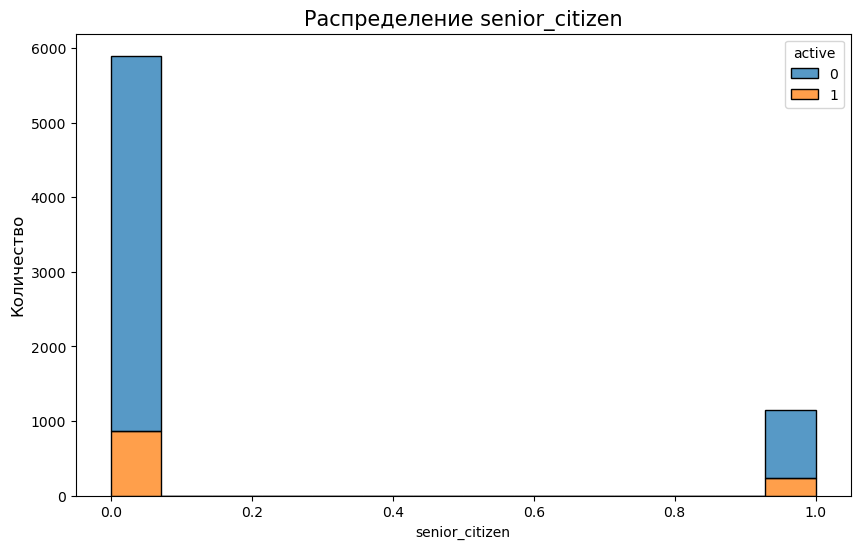

In [40]:
plt.figure(figsize=(10, 6))

sns.histplot(data=telecom, x='senior_citizen', hue='active', multiple='stack')

plt.title('Распределение senior_citizen', fontsize=15)
plt.ylabel('Количество', fontsize=12);

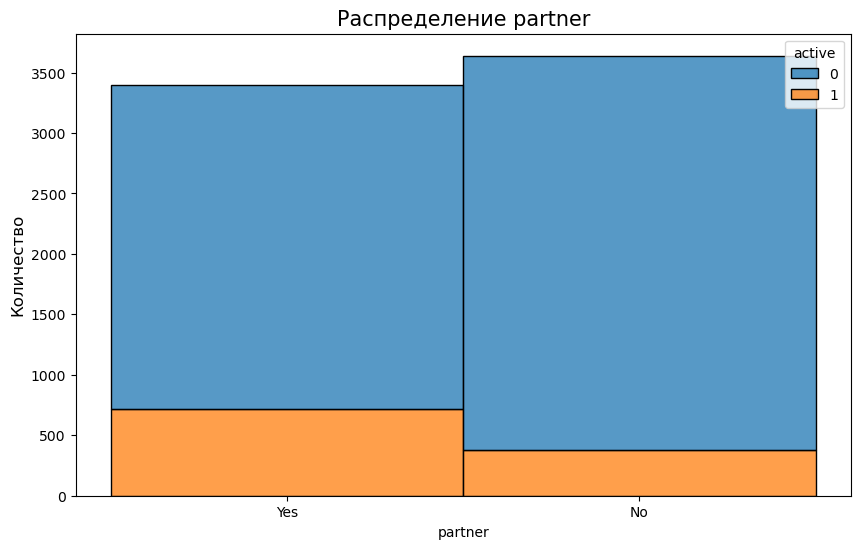

In [41]:
plt.figure(figsize=(10, 6))

sns.histplot(data=telecom, x='partner', hue='active', multiple='stack')

plt.title('Распределение partner', fontsize=15)
plt.ylabel('Количество', fontsize=12);

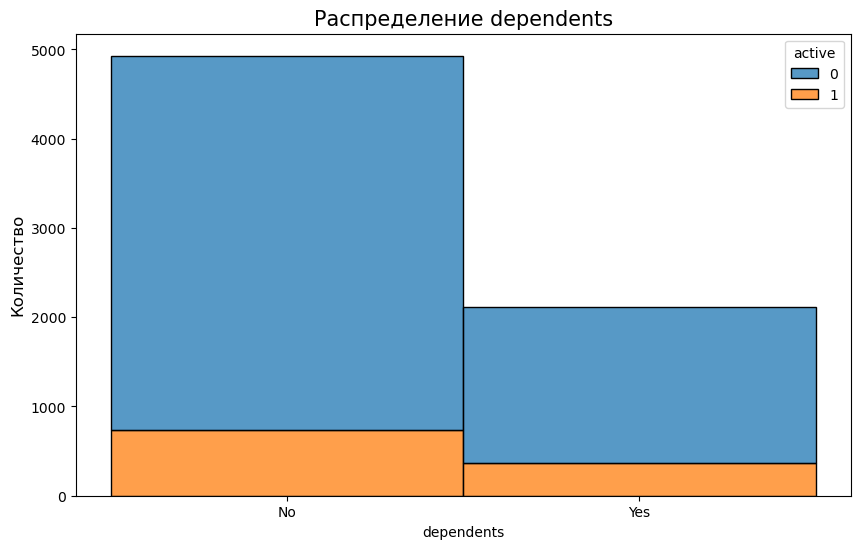

In [42]:
plt.figure(figsize=(10, 6))

sns.histplot(data=telecom, x='dependents', hue='active', multiple='stack')

plt.title('Распределение dependents', fontsize=15)
plt.ylabel('Количество', fontsize=12);

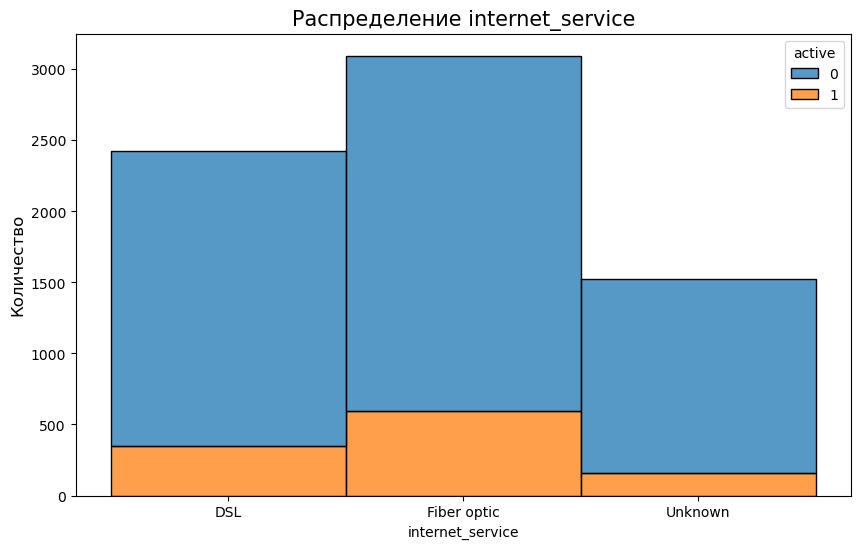

In [43]:
plt.figure(figsize=(10, 6))

sns.histplot(data=telecom, x='internet_service', hue='active', multiple='stack')

plt.title('Распределение internet_service', fontsize=15)
plt.ylabel('Количество', fontsize=12);

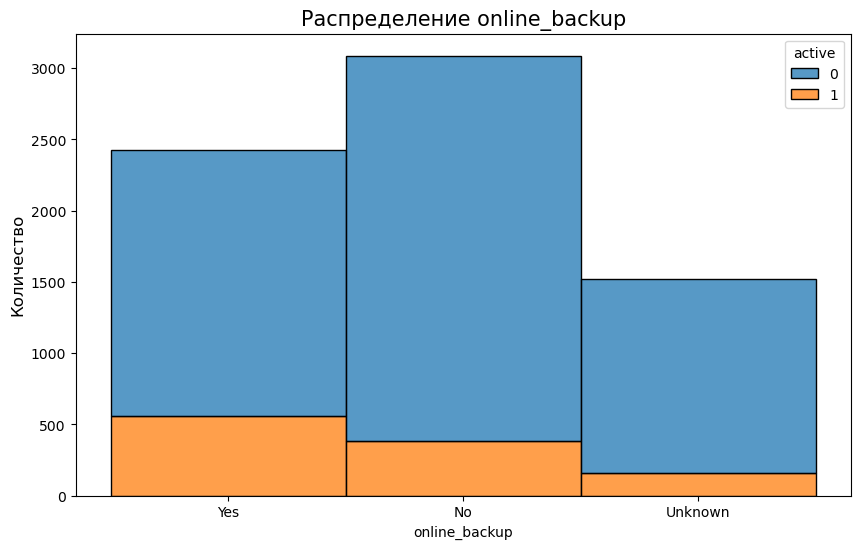

In [44]:
plt.figure(figsize=(10, 6))

sns.histplot(data=telecom, x='online_backup', hue='active', multiple='stack')

plt.title('Распределение online_backup', fontsize=15)
plt.ylabel('Количество', fontsize=12);

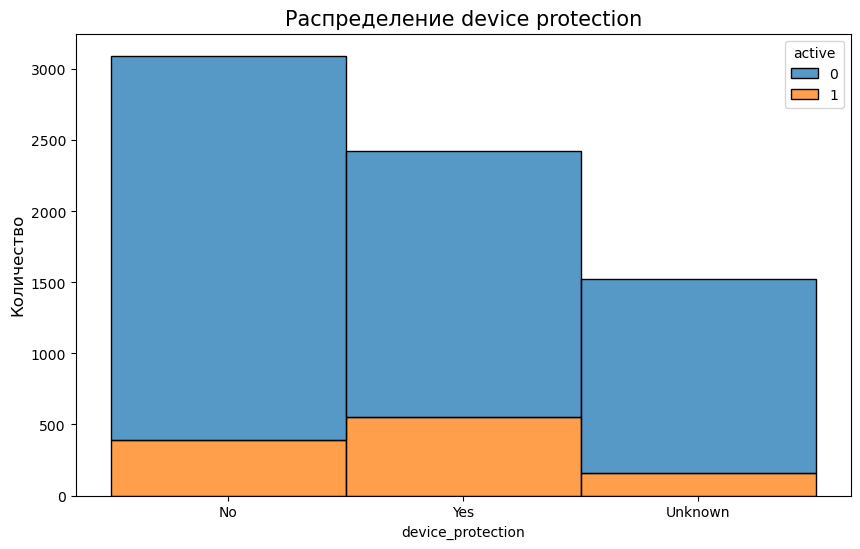

In [45]:
plt.figure(figsize=(10, 6))

sns.histplot(data=telecom, x='device_protection', hue='active', multiple='stack')

plt.title('Распределение device protection', fontsize=15)
plt.ylabel('Количество', fontsize=12);

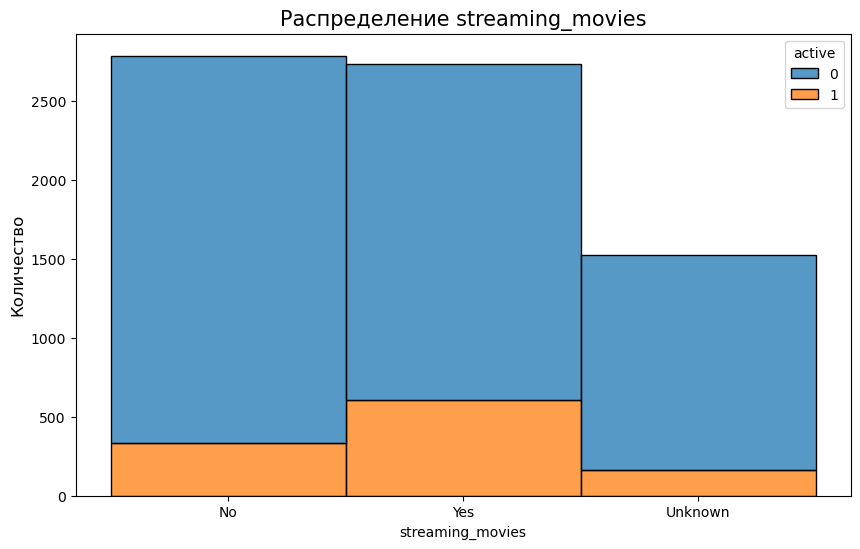

In [46]:
plt.figure(figsize=(10, 6))

sns.histplot(data=telecom, x='streaming_movies', hue='active', multiple='stack')

plt.title('Распределение streaming_movies', fontsize=15)
plt.ylabel('Количество', fontsize=12);

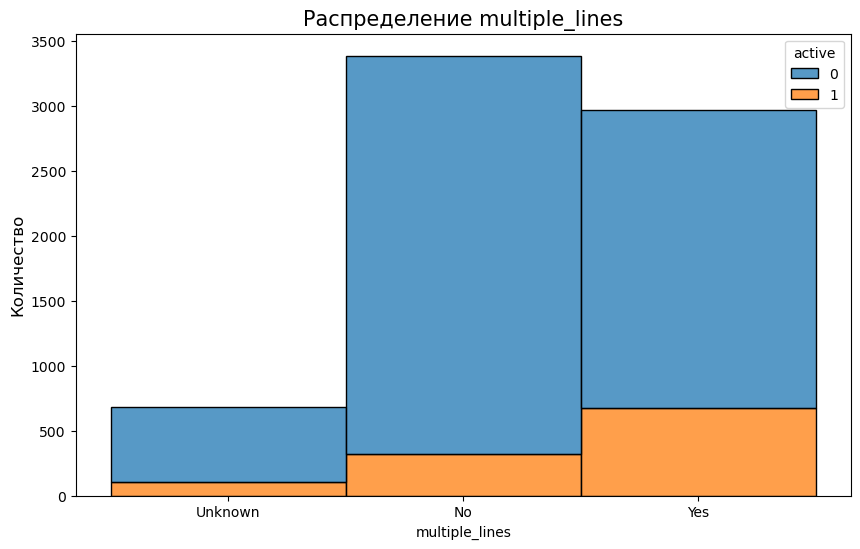

In [47]:
plt.figure(figsize=(10, 6))

sns.histplot(data=telecom, x='multiple_lines', hue='active', multiple='stack')

plt.title('Распределение multiple_lines', fontsize=15)
plt.ylabel('Количество', fontsize=12);

**Вывод:**

Портрет клиента, который ушел:
- Заключал ежемесячный или двухгодичный договор
- Использует оплату по электронному чеку
- Тратит в месяц около 100 руб. Начиная с расходов от 70 руб. в мес постепенно возрастает вероятность ухода клиента.
- Уходит после 3х лет использования услуг. В большей зоне риска клиенты, пользующиеся услугами от года до трех лет.
- Пол не оказывает влияние на пользование абонента услугами связи. 
- Состоит в браке.
- Не имеет детей.
- Использует облачное хранилище. Возможно облачное хранилище заказчика не достаточно фнкционально или невыгодно. 
- Использует антивирус.
- Использовует стриминговые сервисы.
- Подключен к нескольким линиям.

Портрет клиента, который остался:
- Заключил ежемесячный договор
- Также предпочитает электронный чек
- Тратит около 20 руб. в месяц.
- Пользуется услугами около года. 
- Клиенты пожилого возраста реже отказываются от привычного и меняют оператора связи. 
- Не состоит в браке. 
- Не использует облачное хранилище. 
- Не использует антивирус. 
- Не испольует стриминговые сервисы. 
- Имеет одну телефонную линию.

Итого, в группе риска находятся абоненты, которые активно используют дополнительные услуги и функциональность. Стоит обратить внимание на стоимость, наполненность и удобство данных услуг и сервисов.
Также рекомендуем оказывать особое внимание клиентам, пользующимся услугами от года до 3х лет. В этот период возрастает вероятность смены оператора.

Более стабильны люди старшего поколения, пользующиеся одной линей для звонков, с минимальными расходами на связь.
Также риск перехода снижается, если абонент пользуется связью более 3х лет. 

Рассмотрим корреляцию признаков с целевым признаком active на хитмапе:

,type,paperless_billing,payment_method,monthly_charges,total_charges,active,duration,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines
type,1.000000,0.107076,0.277436,0.388089,0.470448,0.094073,0.586432,0.000000,0.086227,0.179447,0.147569,0.505769,0.637001,0.581839,0.631674,0.671733,0.549790,0.553779,0.243135
paperless_billing,0.107076,1.000000,0.369684,0.467018,0.201091,0.083159,0.068167,0.000000,0.241965,0.013973,0.173503,0.231074,0.207967,0.194901,0.195274,0.200237,0.204304,0.201824,0.099860
payment_method,0.277436,0.369684,1.000000,0.398906,0.335268,0.214624,0.433763,0.000000,0.292447,0.242734,0.225051,0.323494,0.315245,0.292835,0.297348,0.317163,0.283987,0.284979,0.174813
monthly_charges,0.388089,0.467018,0.398906,1.000000,0.710725,0.225959,0.285205,0.011139,0.304566,0.202848,0.185006,0.918958,0.812555,0.818792,0.827254,0.816521,0.864601,0.863600,0.710072
total_charges,0.470448,0.201091,0.335268,0.710725,1.000000,0.304025,0.700282,0.000000,0.135821,0.381390,0.083482,0.489951,0.516497,0.550489,0.558237,0.527704,0.555219,0.553840,0.467674
active,0.094073,0.083159,0.214624,0.225959,0.304025,1.000000,0.347892,0.009029,0.085995,0.226776,0.046841,0.056527,0.058587,0.089683,0.085582,0.051437,0.078503,0.086546,0.105152
duration,0.586432,0.068167,0.433763,0.285205,0.700282,0.347892,1.000000,0.028491,0.072187,0.425107,0.186503,0.109544,0.322401,0.340993,0.346522,0.329507,0.284631,0.282034,0.306145
gender,0.000000,0.000000,0.000000,0.011139,0.000000,0.009029,0.028491,1.000000,0.000000,0.000000,0.000000,0.000000,0.001951,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
senior_citizen,0.086227,0.241965,0.292447,0.304566,0.135821,0.085995,0.072187,0.000000,1.000000,0.017018,0.324714,0.160675,0.127201,0.109890,0.110070,0.135167,0.111622,0.113693,0.087972
partner,0.179447,0.013973,0.242734,0.202848,0.381390,0.226776,0.425107,0.000000,0.017018,1.000000,0.652047,0.000000,0.091110,0.091936,0.100019,0.076228,0.082180,0.077434,0.085937


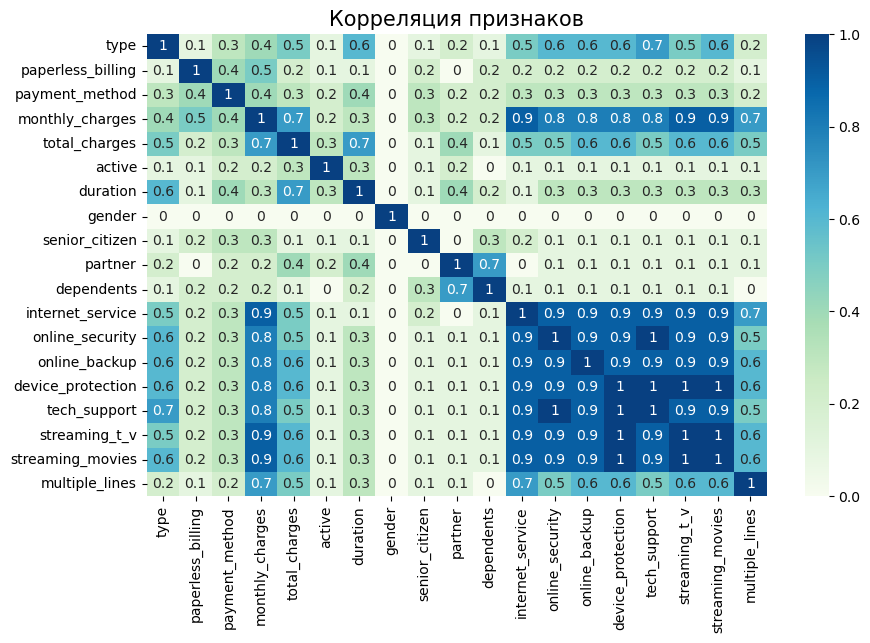

In [48]:
numeric = ['monthly_charges', 'total_charges', 'active', 'duration', 'senior_citizen']
multicol = telecom.phik_matrix(interval_cols=numeric)
display(multicol)

plt.figure(figsize=(10, 6))
sns.heatmap(multicol.copy().round(1), annot=True, cmap='GnBu')
plt.title('Корреляция признаков', fontsize=15);

**Вывод:**

Рассмотрена корреляция признаков на хитмапе, чтобы исключить проблему мультиколлинеарности количественных данных, а также определить влияние признаков на таргет. 

- Выделены признаки, подходящие для обучения и имеющее наибольшее влияние на таргет в порядке убывания важности:

  - monthly_charges
  - total_charges
  - duration
  - payment_method
  - partner
  - type
  - multiple_lines
  - online_backup
  - streaming_movies
  - device_protection

- Обнаружена высокая корреляция (0.7) численного признака total_charges с двумя другими количественными признаками: monthly_charges и duration. Чтобы избежать мультиколлинеарности, можно удалить один из столбцов с расходами перед обучением модели. Так как у total_charges выше корреляция с таргетом, возьмем его для дальнейшего обучения. 

Рекомендации:

Так как, наиболее сильно на отток клиентов влияют расходы, и корреляция других признаков небольшая, для большей эффективности обучения моделей рекомедуется собрать более детальную информацию о расходах абонентов с разбивкой на категории, например:
телефон, интернет, стриминговые сервисы, услуги и пр. 

Это позволит выявить проблемы более точечно и ответить на вопрос, в каких сервисах клиентов не устраивает цена или соотношение цена-качество\наполнение. Какие доп. услуги наиболее популярны.
Вероятно, также существует запрос на более выгодные, обновленные пакетные предложения для клиентов активно использующих доп. услуги и сервисы.

## 5. Подготовка данных

Обновим датафрейм для обучения, оставим целевой признак и признаки наиболее сильно на него влияющие.

In [49]:
telecom = telecom[['active', 'total_charges', 'duration', 'payment_method', 'partner', 'type',
                   'multiple_lines', 'online_backup', 'streaming_movies', 'device_protection']].copy()

Разделим признаки и выборки:

In [50]:
features = telecom.drop(['active'], axis=1)
target = telecom['active']

In [51]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=R_STATE, stratify=target)

display(features_train, features_test, target_train, target_test)

,total_charges,duration,payment_method,partner,type,multiple_lines,online_backup,streaming_movies,device_protection
5986,957.72,1,Credit card (automatic),No,Month-to-month,No,No,Yes,No
1488,53.30,0,Mailed check,No,Month-to-month,No,No,No,No
409,100.94,1,Mailed check,No,Month-to-month,No,Unknown,Unknown,Unknown
1729,4830.30,5,Bank transfer (automatic),Yes,One year,Yes,Yes,No,Yes
1839,101.20,1,Credit card (automatic),No,Two year,Yes,Unknown,Unknown,Unknown
...,...,...,...,...,...,...,...,...,...
6080,118.80,1,Mailed check,No,Month-to-month,Unknown,No,No,No
319,3202.50,3,Credit card (automatic),Yes,Month-to-month,Yes,No,No,No
3727,723.53,1,Electronic check,No,Month-to-month,Yes,No,Yes,No
2528,881.10,1,Bank transfer (automatic),No,Month-to-month,No,No,No,No


,total_charges,duration,payment_method,partner,type,multiple_lines,online_backup,streaming_movies,device_protection
506,858.00,1,Mailed check,No,Month-to-month,Yes,No,No,Yes
1218,2687.52,3,Credit card (automatic),No,Month-to-month,Yes,Yes,No,No
4894,2465.75,3,Credit card (automatic),Yes,One year,Yes,Yes,No,Yes
1887,1412.32,2,Electronic check,No,Month-to-month,Yes,No,No,No
1118,5153.04,4,Credit card (automatic),Yes,Month-to-month,Yes,Yes,Yes,No
...,...,...,...,...,...,...,...,...,...
1165,119.40,0,Credit card (automatic),No,One year,No,Unknown,Unknown,Unknown
6476,1814.16,3,Bank transfer (automatic),Yes,One year,Yes,Yes,No,No
5371,4469.85,3,Bank transfer (automatic),No,One year,Yes,No,Yes,Yes
305,1289.60,5,Mailed check,Yes,Two year,Yes,Unknown,Unknown,Unknown


5986    0
1488    0
409     0
1729    1
1839    0
       ..
6080    0
319     0
3727    0
2528    0
4432    0
Name: active, Length: 5279, dtype: int64

506     0
1218    0
4894    1
1887    0
1118    0
       ..
1165    1
6476    1
5371    1
305     0
2391    0
Name: active, Length: 1760, dtype: int64

Отберем категориальные данные и закодируем с помощью OHE:

In [52]:
columns_cat = ['payment_method', 'partner', 'type',
               'multiple_lines', 'online_backup', 'streaming_movies', 'device_protection']

In [53]:
encoder_ohe = OneHotEncoder(handle_unknown='ignore', drop='first', sparse=False)
encoder_ohe.fit(features_train[columns_cat])
features_train_ohe = features_train.copy()
features_train_ohe[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_train[columns_cat])                                    
features_train_ohe = features_train_ohe.drop(features_train[columns_cat], axis=1)
features_train_ohe = features_train_ohe.reset_index(drop=True)

In [54]:
features_train_ohe.head()

,total_charges,duration,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,partner_Yes,type_One year,type_Two year,multiple_lines_Unknown,multiple_lines_Yes,online_backup_Unknown,online_backup_Yes,streaming_movies_Unknown,streaming_movies_Yes,device_protection_Unknown,device_protection_Yes
0,957.72,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,53.30,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100.94,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4830.30,5,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
4,101.20,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0


**Вывод:**

Проведена подготовка данных к обучению:
- Выделены признаки наиболее сильно влияющие на таргет.
- Выделен целевой признак.
- Данные разделены на обучающую и тестовую выборки в соотношении 75:25.
- Категориальные данные закодированы.

## 6. Обучение моделей машинного обучения

Проведем обучение модели Случайный лес на данных, закодированных OHE:

In [58]:
%%time

model_rfc = RandomForestClassifier()

parameters_rfc = {'max_depth': ([x for x in range(1, 30)]),
                  'random_state': ([20824]), 
                  'class_weight': (['balanced']),
                  'n_estimators': ([1, 50, 100])}

grid_search_rfc = GridSearchCV(model_rfc, param_grid=parameters_rfc, cv=3, scoring=['roc_auc', 'precision', 'recall'], 
                               refit='roc_auc', return_train_score=True)
grid_search_rfc.fit(features_train_ohe, target_train)


best_parametrs_rfc = grid_search_rfc.best_params_
cv_results_rfc = pd.DataFrame.from_dict(grid_search_rfc.cv_results_)
best_idx_rfc = cv_results_rfc.sort_values(by='rank_test_roc_auc').head(1).index[0]
roc_auc_rfc = cv_results_rfc.loc[best_idx_rfc, 'mean_train_roc_auc']
precision_rfc = cv_results_rfc.loc[best_idx_rfc, 'mean_train_precision']
recall_rfc = cv_results_rfc.loc[best_idx_rfc, 'mean_train_recall']


print("Лучшее значение параметров:", best_parametrs_rfc)
print("Лучшая оценка ROC-AUC:", roc_auc_rfc.round(2))
print("Лучшая оценка precision:", precision_rfc.round(2))
print("Лучшая оценка recall:", recall_rfc.round(2))

Лучшее значение параметров: {'class_weight': 'balanced', 'max_depth': 8, 'n_estimators': 100, 'random_state': 20824}
Лучшая оценка ROC-AUC: 0.93
Лучшая оценка precision: 0.5
Лучшая оценка recall: 0.87
CPU times: total: 3min
Wall time: 3min 27s


Проведем обучение модели Логистическая регрессия на данных, закодированных OneHotEncoder:

In [59]:
%%time

pipeline_lr = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression())])

parameters_lr = {'lr__random_state': ([20824]), 
                 'lr__class_weight': (['balanced']),
                 'lr__C': ([0.1, 1, 10])}

grid_search_lr = GridSearchCV(pipeline_lr, param_grid=parameters_lr, cv=3, scoring=['roc_auc', 'precision', 'recall'], 
                              refit='roc_auc', return_train_score=True)
grid_search_lr.fit(features_train_ohe, target_train)

best_parametrs_lr = grid_search_lr.best_params_
cv_results_lr = pd.DataFrame.from_dict(grid_search_lr.cv_results_)
best_idx_lr = cv_results_lr.sort_values(by='rank_test_roc_auc').head(1).index[0]
roc_auc_lr = cv_results_lr.loc[best_idx_lr, 'mean_train_roc_auc']
precision_lr = cv_results_lr.loc[best_idx_lr, 'mean_train_precision']
recall_lr = cv_results_lr.loc[best_idx_lr, 'mean_train_recall']


print("Лучшее значение параметров:", best_parametrs_lr)
print("Лучшая оценка ROC-AUC:", roc_auc_lr.round(2))
print("Лучшая оценка precision:", precision_lr.round(2))
print("Лучшая оценка recall:", recall_lr.round(2))

Лучшее значение параметров: {'lr__C': 10, 'lr__class_weight': 'balanced', 'lr__random_state': 20824}
Лучшая оценка ROC-AUC: 0.8
Лучшая оценка precision: 0.34
Лучшая оценка recall: 0.71
CPU times: total: 641 ms
Wall time: 765 ms


Проведем обучение модели CatBoost на данных, закодированных встроенным кодировщиком модели cat features:

In [60]:
%%time

model_cbc = CatBoostClassifier()

cat_features = ['payment_method', 'partner', 'type',
                'multiple_lines', 'online_backup', 'streaming_movies', 'device_protection']

parameters_cbc = {'random_state': ([20824]),
                  'verbose': ([False]),
                  'class_weights': ([(1, 1), (1, 11)]),
                  'cat_features': ([cat_features])}


grid_search_cbc = GridSearchCV(model_cbc, param_grid=parameters_cbc, cv=3, scoring=['roc_auc', 'precision', 'recall'], 
                               refit='roc_auc', return_train_score=True)
grid_search_cbc.fit(features_train, target_train)


best_parametrs_cbc = grid_search_cbc.best_params_
cv_results_cbc = pd.DataFrame.from_dict(grid_search_cbc.cv_results_)
best_idx_cbc = cv_results_cbc.sort_values(by='rank_test_roc_auc').head(1).index[0]
roc_auc_cbc = cv_results_cbc.loc[best_idx_cbc, 'mean_train_roc_auc']
precision_cbc = cv_results_cbc.loc[best_idx_cbc, 'mean_train_precision']
recall_cbc = cv_results_cbc.loc[best_idx_cbc, 'mean_train_recall']


print("Лучшее значение параметров:", best_parametrs_cbc)
print("Лучшая оценка ROC-AUC:", roc_auc_cbc.round(2))
print("Лучшая оценка precision:", precision_cbc.round(2))
print("Лучшая оценка recall:", recall_cbc.round(2))

Лучшее значение параметров: {'cat_features': ['payment_method', 'partner', 'type', 'multiple_lines', 'online_backup', 'streaming_movies', 'device_protection'], 'class_weights': (1, 1), 'random_state': 20824, 'verbose': False}
Лучшая оценка ROC-AUC: 0.94
Лучшая оценка precision: 0.87
Лучшая оценка recall: 0.54
CPU times: total: 16min 38s
Wall time: 8min 39s


**Вывод:**

Обучили  данные на трех моделях: Случайный лес, Логистическая регрессия и CatBoost.

Получили следующие результаты:

1) Случайный лес:

- Лучшее значение параметров: {'class_weight': 'balanced', 'max_depth': 8, 'n_estimators': 100, 'random_state': 20824}
- Лучшая оценка ROC-AUC: 0.93
- Лучшая оценка precision: 0.5
- Лучшая оценка recall: 0.87

2) Логистическая регрессия:

- Лучшее значение параметров: {'lr__C': 10, 'lr__class_weight': 'balanced', 'lr__random_state': 20824}
- Лучшая оценка ROC-AUC: 0.8
- Лучшая оценка precision: 0.34
- Лучшая оценка recall: 0.71

3) CatBoost:

- Лучшее значение параметров: {'class_weights': (1, 1), 'random_state': 20824, 'verbose': False}
- Лучшая оценка ROC-AUC: 0.94
- Лучшая оценка precision: 0.87
- Лучшая оценка recall: 0.54

## 7. Выбор лучшей модели

Лучший результат метрики AUC-ROC показала модель CatBoost:

In [61]:
column=['ROC-AUC','Precision','Recall']

comparison_table = pd.DataFrame(index=['ROC-AUC','Precision','Recall'], 
                                columns=['RandomForestClassifier', 'LogisticRegression', 'CatBoostClassifier'])
comparison_table['RandomForestClassifier'] = roc_auc_rfc.round(2), precision_rfc.round(2), recall_rfc.round(2)
comparison_table['LogisticRegression'] = roc_auc_lr.round(2), precision_lr.round(2), recall_lr.round(2)
comparison_table['CatBoostClassifier'] = roc_auc_cbc.round(2), precision_cbc.round(2), recall_cbc.round(2)

comparison_table

,RandomForestClassifier,LogisticRegression,CatBoostClassifier
ROC-AUC,0.93,0.80,0.94
Precision,0.50,0.34,0.87
Recall,0.87,0.71,0.54


Рассмотрим важность признаков на лучшей модели:

In [62]:
importances = grid_search_cbc.best_estimator_.feature_importances_
shap_importances = pd.Series(importances, index=features_train.columns).sort_values(ascending=False)

shap_importances.round(2)

duration             35.48
total_charges        24.87
type                 10.32
multiple_lines        8.39
payment_method        5.02
online_backup         4.37
device_protection     4.08
partner               3.80
streaming_movies      3.68
dtype: float64

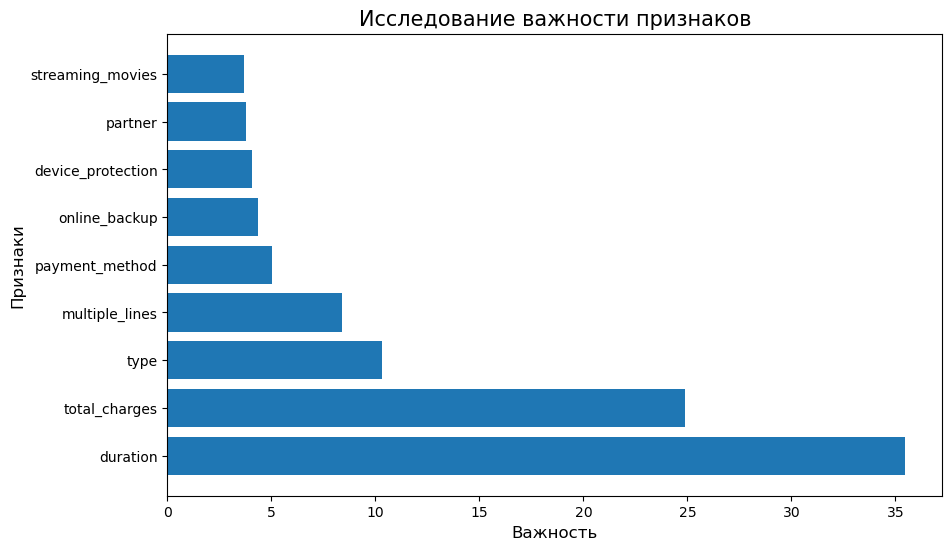

In [63]:
plt.figure(figsize=(10, 6))
plt.barh(shap_importances.index, shap_importances.values)
plt.title('Исследование важности признаков', fontsize=15)
plt.xlabel('Важность', fontsize=12)
plt.ylabel('Признаки', fontsize=12);

Наиболее важными факторами влияющими на уход клиента является длительность договора, ежемесячные расходы абонента и тип оплаты.

Протестируем лучшую модель - CatBoost на тестовой выборке:

In [64]:
roc_auc_t = roc_auc_score(target_test, grid_search_cbc.predict_proba(features_test)[:, 1])

print('ROC-AUC =', roc_auc_t.round(2))


ROC-AUC = 0.9


In [65]:
predict_t = grid_search_cbc.predict(features_test)

precision_t = precision_score(target_test, predict_t)
recall_t = recall_score(target_test, predict_t)

print('Precision =', precision_t.round(2))
print('Recall =', recall_t.round(2))

Precision = 0.79
Recall = 0.49


Рассмотрим матрицу ошибок:

In [66]:
confusion_matrix = pd.DataFrame(confusion_matrix(target_test, predict_t),
                                columns = ['Forecast 0', 'Forecast 1'],
                                index = ['Actual 0', 'Actual 1'])

confusion_matrix

,Forecast 0,Forecast 1
Actual 0,1450,35
Actual 1,141,134


Из матрицы видим, что, если 0 - это negative:

In [67]:
false_positive = 35
false_negative = 141
total_confusion = false_positive + false_negative

print(f'Итого, алгоритм ошибся {total_confusion} раз')

Итого, алгоритм ошибся 176 раз


In [68]:
accuracy = accuracy_score(target_test, predict_t)
error_rate = (1 - accuracy).round(2) * 100

print(f'Ошибки составляют {error_rate}% предсказаний')

Ошибки составляют 10.0% предсказаний


Проверим адекватность модели на dummy:

In [69]:
model = DummyClassifier()
model.fit(features_train, target_train)

predictions_DR = model.predict(features_test)
roc_auc = roc_auc_score(target_test, predict_t)

print('ROC-AUC =', roc_auc.round(2))

ROC-AUC = 0.73


**Вывод:** 

- Выбрали лучшую модель - CatBoost 
- Исследовали важность признаков на лучшей модели:
  - duration             35.48
  - total_charges        24.87
  - type                 10.32
  - multiple_lines        8.39
  - payment_method        5.02
  - online_backup         4.37
  - device_protection     4.08
  - partner               3.8
  - streaming_movies      3.68

Полученный результат подтверждает выводы, полученные в результате изучения корреляции перед обучением модели: наиболее важными фактороми влияющими на уход клиента является длительность договора и расходы абонента.

- Протестировали лучшую модель на тестовой выборке. Получили следующие результаты метрик:
  - ROC-AUC = 0.9
  - Precision = 0.79
  - Recall = 0.49

Результаты теста незначитьльно отличаются от результатов на обучающей выборке.

- Рассмотрели матрицу ошибок:
Алгоритм ошибся 176 раз, ошибки составляют 10.0% предсказаний. 

- Проверили модель на DummyClassifier, получили результат - 0.73.
Т.к. результат хуже, чем на обученной модели, можно сказать, что модель адекватна.

## 8. Общий вывод

Цель исследования - обучить модель для прогноза оттока клиентов. 

В результате была проведена следующая работа и сделаны выводы:

1) Загружены и рассмотрены данные:

Данные представлены в 4 датафреймах.

Contract состоит из 8 столбцов и 7043 строк и содержит категориальные и численные данные. Столбец total charges требует замены типа данных на float.
Personal состоит из 5 столбцов и 7043 строк. Содержит категориальные и численные данные.
Internet состоит из 8 столбцов и 5517 строк, содержит категориальные данные
Phone состоит из 2 столбцов и 6361, содержит категориальные данные

2) Исследование и предобработка данных из датафреймов:
- Провели предобработку данных, проверили на наличие дубликатов и пропусков
- Создали новые столбцы:
  - active с целевым признаком, с информацией о статусе договора из столбца end date
  - duration со сроком действия договоров.
- Использованные столбцы с датами не важны для обучения моделей их нужно будет удалить.
- Выявили дисбаланс классов в таргете - 84:16. Для обучения моделей классы необходимо будет сбалансировать.

- Рассмотрели данные на графиках:
  - Количество завершенных контрактов медленно, но стабильно растет
  - Также после спада в 2015 году уверенно растет и количество новых договоров. Наибольшее количество договоров заключено в 2019 году.
  - Большего всего контрактов закрываются через год, однако большая часть клиентов пользуется услугами от 2 и более лет. Совсем мало тех, кто использует услуги связи меньше года.
  - Информация о расходах за месяц не содержит выбросов. Заказчик не предоставил информацию о валюте расходов, но логически можно предположить, что расходы указаны в рублях. Большая часть клиентов тратит в месяц от 35 до 90 руб. Средняя трата составляет 65 руб. 
  - Информация об общих расходах абонентов содержит большое количество выбросов у верхней границы. Большая часть клиентов потратила в общем от 500 до 3500 руб. Средняя трата составляет 2115 руб.
  
3) Содан общий датафрейм telecom, содержащий 19 столбцов и 6944 строк. Удалили лишние столбцы.

4) Исследование и предобработка общего датафрейма:
- Обработаны пропуски 
- Составлен портрет пользователей, даны рекомедации:

Портрет клиента, который ушел:
- Заключал ежемесячный или двухгодичный договор
- Использует оплату по электронному чеку
- Тратит в месяц около 100 руб. Начиная с расходов от 70 руб. в мес постепенно возрастает вероятность ухода клиента.
- Уходит после 3х лет использования услуг. В большей зоне риска клиенты, пользующиеся услугами от года до трех лет.
- Пол не оказывает влияние на пользование абонента услугами связи. 
- Состоит в браке.
- Не имеет детей.
- Использует облачное хранилище. Возможно облачное хранилище заказчика не достаточно фнкционально или невыгодно. 
- Использует антивирус.
- Использовует стриминговые сервисы.
- Подключен к нескольким линиям.

Портрет клиента, который остался:
- Заключил ежемесячный договор
- Также предпочитает электронный чек
- Тратит около 20 руб. в месяц.
- Пользуется услугами около года. 
- Клиенты пожилого возраста реже отказываются от привычного и меняют оператора связи. 
- Не состоит в браке. 
- Не использует облачное хранилище. 
- Не использует антивирус. 
- Не испольует стриминговые сервисы. 
- Имеет одну телефонную линию.

Итого, в группе риска находятся абоненты, которые активно используют дополнительные услуги и функциональность. Стоит обратить внимание на стоимость, наполненность и удобство данных услуг и сервисов.
Также рекомендуем оказывать особое внимание клиентам, пользующимся услугами от года до 3х лет. В этот период возрастает вероятность смены оператора.

Более стабильны люди старшего поколения, пользующиеся одной линей для звонков, с минимальными расходами на связь.
Также риск перехода снижается, если абонент пользуется связью более 3х лет. 

5) Рассмотрена корреляция признаков на хитмапе, чтобы исключить проблему мультиколлинеарности. Выделены признаки, подходящие для обучения и имеющее наибольшее влияние на таргет в порядке убывания важности:

- monthly_charges
- total_charges
- duratioт
- payment_method
- partner
- type
- multiple_lines
- online_backup
- streaming_movies
- device_protection

Рекомендации:

Так как, наиболее сильно на отток клиентов влияют расходы, и корреляция других признаков небольшая, для большей эффективности обучения моделей рекомедуется собрать более детальную информацию о расходах абонентов с разбивкой на категории, например:
телефон, интернет, стриминговые сервисы, услуги и пр. 

Это позволит выявить проблемы более точечно и ответить на вопрос, в каких сервисах клиентов не устраивает цена или соотношение цена-качество\наполнение. Какие доп. услуги наиболее популярны.
Вероятно, также существует запрос на более выгодные, обновленные пакетные предложения для клиентов активно использующих доп. услуги и сервисы.


6) Данные подготовлены к обучению: 

- Выделены признаки наиболее сильно влияющие на таргет.
- Выделен целевой признак.
- Данные разделены на обучающую и тестовую выборки в соотношении 75:25.
- Категориальные данные закодированы.

7) Обучение данных:

Обучили данные на трех моделях: Случайный лес, Логистическая регрессия и CatBoost.

Получили следующие результаты:

- Случайный лес:

  - Лучшее значение параметров: {'class_weight': 'balanced', 'max_depth': 8, 'n_estimators': 100, 'random_state': 20824}
  - Лучшая оценка ROC-AUC: 0.93
  - Лучшая оценка precision: 0.5
  - Лучшая оценка recall: 0.87

- Логистическая регрессия:

  - Лучшее значение параметров: {'lr__C': 10, 'lr__class_weight': 'balanced', 'lr__random_state': 20824}
  - Лучшая оценка ROC-AUC: 0.8
  - Лучшая оценка precision: 0.34
  - Лучшая оценка recall: 0.71

- CatBoost:

  - Лучшее значение параметров: {'class_weights': (1, 1), 'random_state': 20824, 'verbose': False}
  - Лучшая оценка ROC-AUC: 0.94
  - Лучшая оценка precision: 0.87
  - Лучшая оценка recall: 0.54
  
8) Выбор лучшей модели:

- Выбрали лучшую модель - CatBoost 
- Исследовали важность признаков на лучшей модели:
  - duration             35.48
  - total_charges        24.87
  - type                 10.32
  - multiple_lines        8.39
  - payment_method        5.02
  - online_backup         4.37
  - device_protection     4.08
  - partner               3.8
  - streaming_movies      3.68

Полученный результат подтверждает выводы, полученные в результате изучения корреляции перед обучением модели: наиболее важными фактороми влияющими на уход клиента является длительность договора и расходы абонента.

- Протестировали лучшую модель на тестовой выборке. Получили следующие результаты метрик:
  - ROC-AUC = 0.9
  - Precision = 0.79
  - Recall = 0.49

Результаты теста незначитьльно отличаются от результатов на обучающей выборке.

- Рассмотрели матрицу ошибок:
Алгоритм ошибся 176 раз, ошибки составляют 10.0% предсказаний. 

- Проверили модель на DummyClassifier, получили результат - 0.73.
Т.к. результат хуже, чем на обученной модели, можно сказать, что модель адекватна.